# Classification of Satellite Superspectral Images

In this exercise, we will implement two deep learning approaches for classifying images of agricultural parcels from Sentinel2 multispectral images.
We will implement a **Multi-Layer Perceptron** and a **Convolutional Classifier**.

$\qquad\qquad\qquad\qquad$<img src="https://drive.google.com/uc?id=1sNyYsrExnr6j1YyprhpyllRzgMeepJVU" alt="Teaser"  width="500"/>

The data considered is composed of around $4000$ agricultural parcels for the training test and $2000$ parcels for the test set. Each parcel is a $10\times32\times32$ image of resolution $32\times 32$ with $10$ spectral bands, captured with the Sentinel-2 optical satellite.

The selected parcels follow a nomenclature of $8$ agricultural classes:

> **Class Index** | **Class Name**
> --- | ---
> 0  | Meadow
> 1  | Durum Wheat
> 2  | Spring Cereal
> 3  | Sorgho
> 4  | Leguminous
> 5  | Fodder
> 6  | Ligneous
> 7  | Grapevine



Throughout this exercise, we will implement a full deep learning pipeline brick by brick. The structure of the code is already implemented, you will have to complete some of the code denoted by the following flag: ```#TODO```

I have added some assertions in the code `assert` to check your code. only go to the next question if the assert passes succesfuly.

Since this is a notebook, it can be a bit cumbersome to debug. Do not hesitate to create extra cell and visualize the content of the tensors. Alternatively, I encourage you to add `print` to visualize the shape and content of tensors.


## Preliminaries

First do `Select File→Save a copy in Drive`. Then select `Runtime→Change runtime type` and select `GPU`.

Let's first start by importing and installing the necessary libraires:

In [3]:
#install on the VM libraries that are not installed by default
#!pip install torchnet
#!pip install PyDrive
#!pip install mock
#general purpose libraires
import math
import numpy as np
from functools import partial
import mock
#format libraries
#import h5py
#visualization libraries
%matplotlib inline
import matplotlib.pyplot as plt
#machine learning tools
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
#deep learning tools
import torch
import torchnet as tnt
import torch.nn.functional as nnf
import torch.nn as nn
import torch.optim as optim
from tqdm.auto import tqdm
import pickle, requests

ModuleNotFoundError: No module named 'torch'

Let's now download the data from the provided shared links and directly load the files with pickle.

In [3]:
#data_train_raw = pickle.loads(requests.get('https://owncloud.iscpif.fr/index.php/s/weHpSN8JfyST7N4/download', verify=False, timeout=10).content)
#labels_train = pickle.loads(requests.get('https://owncloud.iscpif.fr/index.php/s/5w7EzYYK2RSpMZ9/download', verify=False).content)
#data_test_raw = pickle.loads(requests.get('https://owncloud.iscpif.fr/index.php/s/3N6tejyiixcdaoy/download', verify=False).content)
#labels_test = pickle.loads(requests.get('https://owncloud.iscpif.fr/index.php/s/WCTjzR4yFyCSYBc/download', verify=False).content)
data_train_raw = pickle.load(open('/content/train_data.pkl','rb'))
labels_train = pickle.load(open('/content/train_labels.pkl','rb'))
data_test_raw = pickle.load(open('/content/test_data.pkl','rb'))
labels_test = pickle.load(open('/content/test_labels.pkl','rb'))

# Reindex labels
unique_labels = np.unique(labels_train)
labels_train = [np.where(unique_labels == label)[0][0] for label in labels_train]
labels_test = [np.where(unique_labels == label)[0][0] for label in labels_test]

FileNotFoundError: [Errno 2] No such file or directory: '/content/train_data.pkl'

In [10]:
print(data_train_raw.shape)
print(data_test_raw.shape)

(4227, 10, 32, 32)
(2173, 10, 32, 32)


The dataset is comprised of $4227$ patches of $10 \times 32\times 32$ for for training, and $2173$ for testing. The parcels only occupy part of the image, the rest of the images have been padded with zero representing the `nodata` v
value.

4227 tiles for training, 2173 tiles for testing
Train is of size: 4227 x 10 x 32 x 32
Meadow        :  143 samples
Durum Wheat   : 1238 samples
Spring Cereal : 1238 samples
Sorgho        :  352 samples
Leguminous    :  631 samples
Fodder        :  464 samples
Ligneous      :   95 samples
Grapevine     :   66 samples


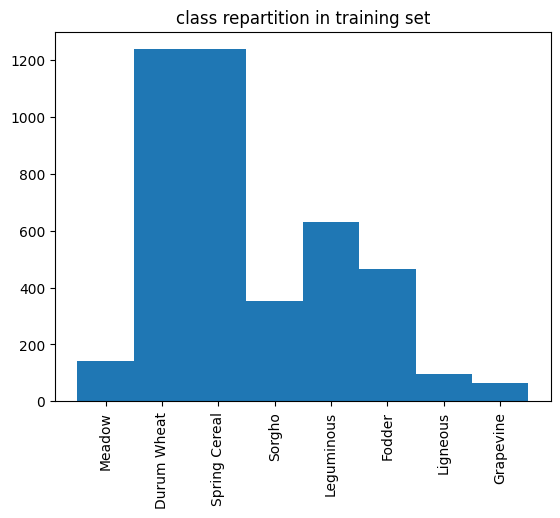

In [11]:
n_train = data_train_raw.shape[0]
n_test = data_test_raw.shape[0]
class_names = ["Meadow", "Durum Wheat", "Spring Cereal", "Sorgho", "Leguminous", "Fodder", "Ligneous", "Grapevine"]

print("%d tiles for training, %d tiles for testing" % (n_train, n_test))
print("Train is of size: %d x %d x %d x %d" % (data_train_raw.shape))

freq = plt.hist(labels_train, bins=8, range=(0,8))
plt.xticks(ticks=[0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5], labels=class_names, rotation='vertical')
plt.title("class repartition in training set")
print('\n'.join('{:13s} : {:4.0f} samples'.format(name, freq[0][i]) for i, name in enumerate(class_names)))

## Data Normalization

Q1) In machine learning in general, and deep learning in particular, it is important for the data to be normalized. Complete the next cell to normalize the train set such that all channels to be of mean $0$ and deviation $1$ over all pixels of all images. Apply the same normalization to the test set, **with the empirical values obtained from the training set.**

<font color='red'>Why is it important to normalize the test set with the empirical values obtained from the training set and not the test set?</font>



In [15]:
#compute mean and std values for normalizing
#we keep the original dimension to facilitate broadcasting
means = np.mean(data_train_raw,axis=(0,2,3), keepdims=True)
stds = np.std(data_train_raw, axis=(0,2,3), keepdims=True)
print("Means = ")
print(means[0,:,0,0])
print("STDs = ")
print(stds[0,:,0,0])

#normalize raw data to be of mean 0 and std 1
data_train = (data_train_raw - means)/stds
data_test = (data_test_raw - means)/stds

#check that the code is correct
assert(np.all([np.abs(np.mean(data_train[:,i]))<1e-4 for i in range(10)]))
assert(np.all([np.abs(np.std(data_train[:,i])-1)<1e-4 for i in range(10)]))

Means = 
[ 403.79485349  456.28882731  472.63935133  634.06778065  979.3300668
 1080.45327517 1109.53440494 1173.4102318   787.45794798  525.9597202 ]
STDs = 
[ 673.76011104  686.96785549  725.41494535  856.83833441 1238.1736298
 1362.12469092 1398.17960585 1466.60678431  990.05615483  696.21745162]



## Data Loader

Any deep learning pipeline rely on a dataloader, which loads a single element (here a patch). Read and understand the function.
Complete the function to compute the patch-wise spatial average  if `average=True`.

In [16]:
def patch_loader(patch_index, train=True, average=False):
  """
  load a patch and returns the observation and associated ground truth
  INPUT:
  tile_index = int, index of the tile
  train = bool, train = True if in the train set, False for the test set
  average = if True, compute the spatial average of spectral bands, otherwise returns an image
  OUTPUT
  patch, if average=True [10] float tensor, otherwise [10 x 32 x 32]  float tensor
  label, long int, containing the ground truth class
  """
  if train:
    patch = data_train[patch_index,:,:,:]
    label = labels_train[patch_index]
  else:
    patch = data_test[patch_index,:,:,:]
    label = labels_test[patch_index]

  if average:#spatial average on all pixels of the parcel:
    patch = np.mean(patch,axis=(1,2))

  #create torch tensors
  patch = torch.from_numpy(patch.astype('f4')) #use float to save space
  label = torch.Tensor([label]).long()  #ground truth must have long int type

  return patch, label

In [17]:
patch, label = patch_loader(500)
print("The image patch is of shape : %d x %d x %d" % (patch.shape))
print("and its label is %s" % (class_names[label]))
patch, label = patch_loader(200, average=True)
print("The average patch is of shape : %d" % (patch.shape))
print("and its label is %s" % (class_names[label]))

The image patch is of shape : 10 x 32 x 32
and its label is Durum Wheat
The average patch is of shape : 10
and its label is Durum Wheat


## Data Visualization

Writing some visualization functions to explore the data and the results is very important.
Read and understand the definition of `view_patch_RGB` and `show_random_patches`.

In [19]:
#functions used for visualization
def view_patch_RGB(patch, ax):
  """
  INPUT:
  patch - CxWxH array: the patch to visualize
  ax - subplot axis: in which windows to represent the patch
  """
  patch = np.swapaxes(patch[[2,1,0],:,:],0,-1)
  patch = np.minimum(1,np.maximum(0,(patch+2)/4))
  ax.imshow(patch)
  plt.axis('off')

def show_random_patches(num_patches, train = True):
  """ show random patches values
  INPUT:
  num_patches - int: the number of patches to show
  train - bool: if true loads from the train set, otherwise the test set
  """
  n_row = int(num_patches / 4 + 1) #4 columns
  fig = plt.figure(figsize=(10, n_row * 2.5))
  for i_image in range(num_patches):
    index = np.random.randint(n_train) if train else np.random.randint(n_test)
    patch, label = patch_loader(index, train = train)
    ax = fig.add_subplot(n_row, 4, i_image+1, aspect='equal')
    view_patch_RGB(patch, ax)
    ax.set_title(class_names[label])

Q2) Use the function `show_random_patches` to represent 16 random tiles of the
**test set**.

/tmp/ipython-input-605816213.py:9: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  patch = np.minimum(1,np.maximum(0,(patch+2)/4))


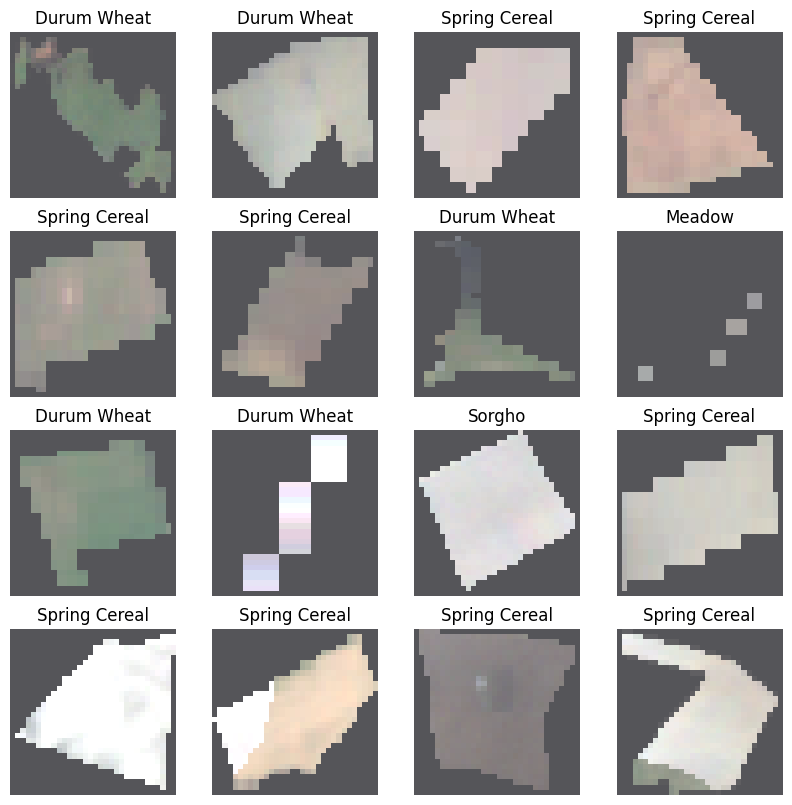

In [20]:
show_random_patches(16, train=False)

## Multi-Layer perceptron

We start by implementing a simple MLP operating on the spatial average of each parcel's spectral channels. This networks maps the vector of size $10$ of the spectral average to a vector of $8$ class scores corresponding to the crop classes.


We now define the architecture of our MLP.

The input layer is of size $C$ (the number of bands, here 10) and the last layer is of size $K$ (the number of classes , here $8$). We add $2$ intermediate representations $x_1$ and $x_2$ of size $d_1$ and $d_2$.

Between each representation we add a fully connected layer FC. After each fully connected except the last one, we add a batchnorm and a ReLU activation.

The equations describing the function defined by the MLP are as follows:
$$\newcommand{\FC}[2]{\text{FC}_{#1}\left(#2\right)}$$
$$\newcommand{\BN}[1]{\text{BatchNorm}\left(#1\right)}$$
$$\newcommand{\RELU}[1]{\text{ReLU}\left(#1\right)}$$

<img src="https://drive.google.com/uc?id=1qGul7aryVktkb8wm6pEdOHmTnltp5sU5" alt="mlp"  width="500"/>

\begin{align}
x_1  &= \RELU{\BN{\FC{1}{\text{input}}}}\\
x_2  &= \RELU{\BN{\FC{2}{x_1}}}\\
\text{output}  &= \FC{3}{x_2}\\
\end{align}

The size of all tensors is given in the following Table:

> **Tensor**           |    **shape**   |
> -------------------- | -------------------------------------------------|
> input                |  $C$                           |
> $x_1$                |  $d_1$                         |
> $x_2$                |  $d_2$                         |
> output               |  K

Q3 Complete the following cell to create the layer and implement the forward function. <font color='red'>Give the formula for the number of parameters (weights) in  $\text{FC}_1$ (don't forget the biases).</font>

In [ ]:
class MLP(nn.Module):
  """
  MLP network for classification
  """

  def __init__(self, n_channels, hidden_width,  n_class, cuda=1):
    """
    initialization function
    n_channels, int, number of input channel
    hidden_width, int list, width of hidden layers
    n_class = int,  the number of classes
    """
    super(MLP, self).__init__() #necessary for all classes extending the module class

    self.is_cuda = cuda

    self.fc1 = nn.Sequential( \
        nn.Linear(in_features=n_channels, out_features=hidden_width[0]), \
        nn.BatchNorm1d(num_features=hidden_width[0]), \
        nn.ReLU(True))
    self.fc2 = nn.Sequential( \
        nn.Linear( in_features= hidden_width[0],out_features=hidden_width[1]), \
        nn.BatchNorm1d(num_features=hidden_width[1]), \
        nn.ReLU(True))
    self.fc3 = nn.Linear(in_features=hidden_width[1],out_features=n_class)
    #no activation and norm after last layer!

    if cuda: #put the model on the GPU memory
      self.cuda()

  def forward(self,input):
    """
    the foward pass : maps input to output
    """
    if self.is_cuda: #input to the GPU at the last second to save some VRAM
      input = input.cuda()

    x1 = self.fc1(input)
    x2 = self.fc2(x1)
    output = self.fc3(x2)
    return output

In [ ]:
#==================TEST===============================
#make a batch of 2 patches
patch1, label = patch_loader(0, average=True)
patch2, label = patch_loader(1, average=True)
patches = torch.cat((patch1[None,:],patch2[None,:]),0)
#create classifier
mlp = MLP(10,[128,128],8)
#print layers + number of parameters
print(mlp)
print('Total number of parameters: {}'.format(sum([p.numel() for p in mlp.parameters()])))
#classify batch
pred = mlp(patches)
#check the shape of the outcome
assert(pred.shape == torch.Size([2,8]))


## Evaluation Metrics

Q5 Complete the metric functions belows, defined with respect to the confusion matrix $M$ of size $K \times K$:

* *Overall Accuracy*: a global metric defined as the ratio of correct prediction divided by the number of (annotated) points
    $$
    OA = \frac{\sum_{i}M_{i,i}}
    {\sum_{i,j}M_{i,j}}~.
    $$
* *Class IoU*: this per-class metric is defined as the ratio between true positives divided by the sum of false positives, false negatives and true positives.
    $$
    IoU_i = \frac{M_{i,i}}
    {M_{i,i} + \sum_{j \neq i}\left(M_{i,j} + M_{j,i} \right)}
    ~.
    $$
We typically compute the per-class averagr IoU to evaluate a classification method.

Make sure you obtain the following:
```
OA = 76,00%
Meadow        : 71.43%
Durum Wheat   : 57.14%
Spring Cereal : 100.00%
Sorgho        : 100.00%
Leguminous    : 100.00%
Fodder        : 66.67%
Ligneous      : 25.00%
Grapevine     : 25.00%
```

In [ ]:
class ConfusionMatrix:
  def __init__(self, n_class, class_names):
    self.CM = np.zeros((n_class, n_class)) #the matrix itself
    self.n_class = n_class
    self.class_names = class_names

  def add_batch(self, gt, pred):
    #add in the CM a batch of prediction and associated ground truth
    self.CM +=  confusion_matrix(gt, pred, labels = list(range(self.n_class)))

  def overall_accuracy(self):#percentage of correct classification
    return #TODO - hint: use np.trace and np.sum

  def class_IoU(self, show = 0):#IoU for each class
    ious = #TODO- hint: use np.diag and np.sum

    if show: #print detailed values
      print('\n'.join('{:13s} : {:3.2f}%'.format(name, 100*iou) for name, iou in zip(self.class_names,ious)))
    #do not count classes that are not present in the dataset in the mean IoU
    return 100*np.nansum(ious) / (np.logical_not(np.isnan(ious))).sum()

In [ ]:
m = ConfusionMatrix(8, class_names)
m.add_batch(np.array([0,1,1,5,2,0,0,4,0,5,3,7,8,6,7]), np.array([0,1,0,5,2,0,1,4,0,5,3,6,7,6,7]))
m.add_batch(np.array([0,1,5,1,2,1,0,2,3,6,7]), np.array([0,1,1,1,2,1,0,2,3,7,6]))
print(m.CM)
print("OA = %3.2f%%" % (100*m.overall_accuracy()))
print("mIoU = %3.2f%%" % (m.class_IoU(show=1)))

Q6) Read in the `train` function following cell. Complete the function `eval`  which performs inference with the trained model. This function computes a prediction and the loss but does not compute gradients nor make an optimizer step.

In [ ]:
def train(model, optimizer, loader, args):
  """train for one epoch
  INPUT:
  model = current model
  optimizer = current optimizer
  loader = dataset constituting the epoch
  args = otptions
  OUTPUT:
  cm = the confusion matrix over the entire epoch
  lm = the average loss
  """
  model.train() #switch the model in training mode

  #tqdm will provide some nice progress bars
  loader = tqdm(loader, ncols=500, leave=False, desc="Train Epoch")

  #will keep track of the loss
  loss_meter = tnt.meter.AverageValueMeter()
  #keep tracks of prediction errors
  cm = ConfusionMatrix(args.n_class, class_names = class_names)

  #goes through the entire dataset
  for index, (tiles, label) in enumerate(loader):

    if model.is_cuda: #put label on GPU
      label = label.cuda()

    optimizer.zero_grad() #put gradient to zero

    pred = model(tiles) #compute the prediction

    loss = nn.functional.cross_entropy(pred,label.squeeze()) #compute the loss

    loss.backward() #compute gradients

    optimizer.step() #one gradient descent step

    #add the loss to the meter
    loss_meter.add(loss.item())
    #fill the confusion matrix
    cm.add_batch(label.cpu().detach().numpy(), pred.argmax(1).view(-1).cpu().detach().numpy())

  return cm, loss_meter.value()[0]

def eval(model, loader, args):
  """
  classify the given dataset. DO NOT track gradients
  INPUT:
  model = model to evaluate
  loader = dataset to classify
  OUTPUT:
  cm = the confusion matrix over the entire dataset
  lm = the average loss
  """

  model.eval() #switch in eval mode

  loader = tqdm(loader, ncols=500, leave=False, desc="Validation")

  loss_meter = tnt.meter.AverageValueMeter()
  cm = ConfusionMatrix(args.n_class, class_names = class_names)

  with torch.no_grad(): #do not compute gradients (saves memory)
    for index, (tiles, label) in enumerate(loader):

     #TODO

  return cm, loss_meter.value()[0]

The following cell is the entire training sequence. Read and understand the structure.

In [ ]:
def train_full(model, args):
  """The full training loop"""

  #create train and test dataset with ListDataset (as list of patch index)
  train_set_average = tnt.dataset.ListDataset(
    list(range(n_train)),partial(patch_loader, train=True, average=args.average))
  test_set_average  = tnt.dataset.ListDataset(
    list(range(n_test)), partial(patch_loader, train=False, average=args.average))

  #the loader function will take care of the batching
  train_loader = torch.utils.data.DataLoader(
      train_set_average, batch_size=args.batch_size, shuffle=True,
      drop_last=True)
  test_loader = torch.utils.data.DataLoader(
      test_set_average, batch_size=args.batch_size, shuffle=False,
      drop_last=False)

  #define the optimizer
  #Adam optimizer is always a good guess for classification tasks
  optimizer = optim.Adam(model.parameters(), lr=args.lr)

  #defines some color for test and train texts
  TESTCOLOR = '\033[104m'
  TRAINCOLOR = '\033[100m'
  NORMALCOLOR = '\033[0m'

  for i_epoch in tqdm(range(args.n_epoch), desc="Training"):
    #train one epoch
    cm_train, loss_train = train(model, optimizer, train_loader, args)
    tqdm.write(TRAINCOLOR + 'Epoch %3d -> Train Overall Accuracy: %3.2f%% Train mIoU : %3.2f%% Train Loss: %1.4f' % (i_epoch, 100*cm_train.overall_accuracy(), cm_train.class_IoU(), loss_train) + NORMALCOLOR)

    #periodic testing
    if (i_epoch == args.n_epoch - 1) or (args.n_epoch_test != 0 and i_epoch % args.n_epoch_test == 0 and i_epoch > 0):
      #evalue performance over the test set
      cm_test, loss_test = eval(model, test_loader, args)
      tqdm.write(TESTCOLOR + 'Test Overall Accuracy: %3.2f%% Test mIoU : %3.2f%%  Test Loss: %1.4f' % (100*cm_test.overall_accuracy(), cm_test.class_IoU(show=1), loss_test) + NORMALCOLOR)
  return model

Q7) Create and train a model with the following parameter in the following cell. You should reach a mIoU of $\sim$ 40\%.

In [ ]:
args = mock.Mock() #stores the parameters
args.n_epoch = 50 #number of epochs
args.n_epoch_test = int(5) #periodicity of evaluation on test set
args.batch_size = 16 #size of batch
args.n_class = 8 #number of classes
args.n_channel = 10 #number of channels
args.cuda = 1 #wether to use the GPU
args.lr = 5e-3 #learning rate
args.hidden_width = [256,256] #size of hidden layers
args.average = True #compute spatial average of each patch

#create the model to train
model = MLP(#TODO
print('Total number of parameters: {}'.format(sum([p.numel() for p in model.parameters()])))

#train the model
trained_model = train_full(#TODO

## Convolutional Classifier

$$\newcommand{\Conv}[2]{\text{Conv}_{#1}\left(#2\right)}$$
$$\newcommand{\FC}[2]{\text{FC}_{#1}\left(#2\right)}$$
$$\newcommand{\BN}[1]{\text{BatchNorm}\left(#1\right)}$$
$$\newcommand{\RELU}[1]{\text{ReLU}\left(#1\right)}$$
$$\newcommand{\MAX}[1]{\text{Maxpool}\left(#1\right)}$$
$$\newcommand{\MEAN}[1]{\text{Mean}\left(#1\right)}$$

<img src="https://drive.google.com/uc?id=1l7e2nYV_dKCGvUopmgw8MxzVINCvtZvO" alt="CNN"  width="500"/>

We will now define a CNN network, more appropriate for image classification.

The input is an image of size $C\times W\times H$ with C the number of bands (here 10) and W and H the width and height (here 32). The output is a vector of size $K$ (the number of classes , here $8$).

The CNN is composed of a sequence of convolutions to extract local radiometric features and maxpooling operations to reduce the size of the feature map. Then the learned features are averaged spatially to obtain a vector of aggregated feature. Finally, a fully connected layer maps this vector to the class vector. All convolutions have a $3\times3$ kernel.

The equations describing the function defined by the CNN are as follows:


\begin{align}
x_1  &= \RELU{\BN{\Conv{1}{\text{input}}}}\\
x_2  &= \RELU{\BN{\Conv{2}{x_1}}}\\
x_3  &= \MAX{x_2}\\
x_4  &= \RELU{\BN{\Conv{3}{x_3}}}\\
x_5  &= \RELU{\BN{\Conv{4}{x_4}}}\\
x_6  &= \MEAN{x_5}\\
\text{output}  &= \FC{1}{x6}\\
\end{align}

The size of all tensors is given in the following Table:

> **Tensor**           |    **&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Shape of Vectors&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**                          |
> -------------------- | --------------------------------------|      
> input                |  $C\times W \times H$                           |
> $x_1$                |  $d_1\times W \times H$                         |
> $x_2$                |  $d_2\times W \times H$                         |
> $x_3$                |  $d_2\times \lceil{{W}/{2}}\rceil \times \lceil{{H}/{2}}\rceil$    |
> $x_4$                |  $d_3\times \lceil{{W}/{2}}\rceil \times \lceil{{H}/{2}}\rceil$                         |
> $x_5$                |  $d_4\times \lceil{{W}/{2}}\rceil \times \lceil{{H}/{2}}\rceil$                         |
> $x_6$                |  $d_4$|
> output               |  $K$


Q8) Complete the following cell to define the convolutional classsifier. Make sure that the assert passes.

<font color='red'>Give the formula for the number of parameters (weights) in  $\text{Conv2}$ (don't forget the biases).</font>

In [ ]:
class CNN(nn.Module):
  """
  CNN network for image classification
  """
  def __init__(self, n_channels, conv_width,  n_class, cuda = 1):
    """
    initialization function
    n_channels, int, number of input channel
    conv_width, int list, width of hidden convolutional layers
    n_class = int,  the number of classes
    """
    super(CNN, self).__init__() #necessary for all classes extending the module class
    self.is_cuda = cuda
    self.class_weight = None #cf Q13 torch.tensor([5., 0.5, 1, 1, 1,1, 0.5 , 1])
    self.maxpool = nn.MaxPool2d(2,2) #maxpooling layer

    self.conv1 = nn.Sequential(
        nn.Conv2d(in_channels=n_channels, out_channels=conv_width[0] , kernel_size=3, padding=1, padding_mode='reflect'), \
        nn.BatchNorm2d(num_features=conv_width[0]), \
        nn.ReLU(True))
    self.conv2 = nn.Sequential( \
        nn.Conv2d(in_channels=#TODO, out_channels#TODO , kernel_size=3, padding=1, padding_mode='reflect'), \
        nn.BatchNorm2d(num_features=#TODO), \
        nn.ReLU(True))
    self.conv3 = nn.Sequential( \
        nn.Conv2d(in_channels=#TODO, out_channels=#TODO , kernel_size=3, padding=1, padding_mode='reflect'), \
        nn.BatchNorm2d(num_features=#TODO), \
        nn.ReLU(True))
    self.conv4 = nn.Sequential( \
        nn.Conv2d(in_channels=#TODO, out_channels=#TODO , kernel_size=3, padding=1, padding_mode='reflect'), \
        nn.BatchNorm2d(num_features=#TODO), \
        nn.ReLU(True))

    self.fc = nn.Linear(in_features=#TODO,out_features=n_class)

    if cuda: #put the model on the GPU memory
      self.cuda()

  def forward(self,input):
    """
    the foward pass : maps input to output
    """
    if self.is_cuda:
      input = input.cuda()

    x1 = #TODO
    x2 = #TODO
    x3 = self.maxpool(x2)
    x4 = #TODO
    x5 = #TODO
    x6 = x5.mean(dim=(2,3))
    output = #TODO
    return output

In [ ]:
#==================TEST===============================
#load a batch of 2 patches
patch1, label = patch_loader(0)
patch2, label = patch_loader(1)
patches = torch.cat((patch1[None,:,:,:],patch2[None,:,:,:]),0)
cnn = CNN(10,[16,32,64,64],8)
print(cnn)
print('Total number of parameters: {}'.format(sum([p.numel() for p in cnn.parameters()])))
pred = cnn(patches)
assert(pred.shape == torch.Size([2,8]))

Q9) Complete the following cell, defining the learning procedure for the CNN.  You should reach a mIoU of $\sim$ 60\%.

In [ ]:
#[12]
args = mock.Mock() #stores the parameters
args.n_epoch = 50
args.n_epoch_test = int(5)
args.batch_size = 16
args.n_class = 8
args.n_channel = 10
args.conv_width = [16,64,64,64]
args.cuda = 1
args.lr = 5e-3
args.average = False

#create the model to train
model = CNN(#TODO
print('Total number of parameters: {}'.format(sum([p.numel() for p in model.parameters()])))

trained_model_CNN = train_full(#TODO

Q10)  Complete the following function which visualizes the feature maps at each step of the model. Launch this viewer on a fully trained model.

<font color='red'>Comment on the interpretability of the model. In particular, can we compare $x_1$ to $x_2$? And $x_2$ to $x_3$?</font>



In [ ]:
def view_patch_false_color(feat_map, ax):
  """
  visualize a feature_map in RGB space
  """
  fmap_dim = feat_map.shape[1]
  n_pix = feat_map.shape[2]
  #we use a pca to project the embeddings to a RGB space
  pca = PCA(n_components=3)
  pca.fit(np.eye(fmap_dim))
  #we need to adapt dimension and memory allocation to CPU
  fmap_ = feat_map.cpu().detach().numpy().squeeze()
  fmap_ = fmap_.reshape((fmap_dim, n_pix * n_pix)).transpose(1,0)
  color = pca.transform(fmap_)
  #we normalize for visibility
  color = np.maximum(np.minimum(((color - color.mean(1, keepdims = True) +0.5) / (2 * color.std(1, keepdims = True))), 1), 0)
  color = color.reshape((n_pix, n_pix,3), order= 'F')
  ax.imshow(color)
  plt.axis('off')

def view_embeddings(model, patch_index = None, train = False):
  """
  view the feature maps at all levels for a give model
  """
  if patch_index is None:
    patch_index = np.random.randint(n_train) if train \
    else np.random.randint(n_test)
  patch, label = patch_loader(patch_index)

  if model.is_cuda:
    patch = patch.cuda()

  #forms a batch of size 1
  input = patch[None,:,:,:]
  with torch.no_grad(): #we do not need  to keep track of gradients here
    x1 = #TODO
    x2 = #TODO
    x3 = #TODO
    x4 = #TODO
    x5 = #TODO
    x6 = #TODO

  fig = plt.figure(figsize=(25, 10)) #adapted dimension
  ax = fig.add_subplot(1, 7, 1, aspect=1)

  ax.set(title='Input : %d x %d x %d \n %s' %(input.shape[1],input.shape[2],input.shape[3], class_names[label]))
  view_patch_RGB(patch.cpu(), ax)
  ax = fig.add_subplot(1, 7, 2, aspect=1)
  ax.set(title='x1 : %d x %d x %d' %(x1.shape[1:]))
  view_patch_false_color(x1, ax)
  ax = fig.add_subplot(1, 7, 3, aspect=1)
  ax.set(title='x2 : %d x %d x %d' %(x2.shape[1:]))
  view_patch_false_color(x2, ax)
  ax = fig.add_subplot(1, 7, 4, aspect=1)
  ax.set(title='x3 : %d x %d x %d' %(x3.shape[1:]))
  view_patch_false_color(x3, ax)
  ax = fig.add_subplot(1, 7, 5, aspect=1)
  ax.set(title='x4 : %d x %d x %d' %(x4.shape[1:]))
  view_patch_false_color(x4, ax)
  ax = fig.add_subplot(1, 7, 6, aspect=1)
  ax.set(title='x5 : %d x %d x %d' %(x5.shape[1:]))
  view_patch_false_color(x5, ax)
  ax = fig.add_subplot(1, 7, 7, aspect=1)
  ax.set(title='x6 : %d' %(x6.shape[1:]))
  view_patch_false_color(x6[:, :, None, None], ax)

In [ ]:
for i in range(3):
  view_embeddings(trained_model_CNN)

$\star$Q11
Study the effect of the batch size and learning rate. Try very small and large values, report the best configurations. In particular, interpret the observed relationship between batch size and learning rate, and propose an explanation.






















$\star$Q12 Add a drop out layer on the previous to last layer of the classifier layer. Try different drop out rate, and comment on the effect, if any.


$\star$Q13 The data set is imbalanced. We can weight the difference classes to  increase the importance of vegetation and buildings. Set the parameter `class_weight` of `CNN` to the tensor:
`[5, 0.5, 1, 1, 1, 1, 0.5 , 1]`, and add it as a class weights option in the cross entropy loss (see pytorch doc) in `train` and `test`. Assess the effect oon the OA and the mIoU, and try other values.

$\star$Q14 Change the width of the convolutions to try to find a better parametrization. What happens when the network gets too large (too many parameters).

$\star$Q15 Implement adaptive learning rates using the `MultiStepLR` scheduler (look up the online torch documentation for usage). Implement a decay of $0.5$ and milestone at epochs $30$ and $40$ when training for $50$ epochs.

$\star$Q16 Implement a random forest baseline operating on the average vector. Compare its performance to the MLP and propose an explanation.

$\star\star$Q17 Study the effect of the quantity of training data by running the two models using only $50\%$, $25\%$, and $10\%$ of the training data.

$\star\star$Q18 Replace the average pooling in the CNN with a spatial maxpooling and comment on the effect. Implement a pooling operation which concatenate the spatial mean and deviation (std) over the parcel, and comment on the effect.

$\star\star$Q19 Create the class `CNN3` which operates has a supplementary maxpool and two more convolutions before the spatial mean (the final layer before averageing is of size $\lceil H/4\rceil \times \lceil W/4 \rceil \times d$. Give the size of the receptive fields for both networks.

Q20 Open question: try to think of other ways to improve the model, and report your reasoning and results.


**Data from**
Garnot, V. S. F., Landrieu, L., Giordano, S., & Chehata, N. Satellite Image Time Series Classification with Pixel-Set Encoders and Temporal Self-Attention. In CVPR 2020.

https://github.com/VSainteuf/pytorch-psetae